In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pomegranate import *
from GEM import GEM


# Generate Mock Data

Observations
$$ \theta_k \sim G\quad\mathrm{for}\;k=1,2,\ldots, n. $$

Data is simulated by drawing numbers from a log-normal distribution

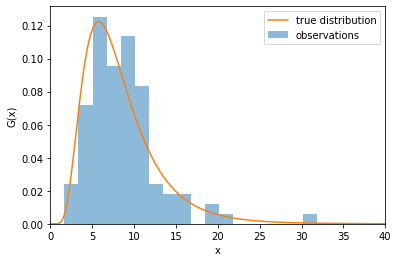

In [132]:
true_dist = LogNormalDistribution(2, 0.5)

observations = true_dist.sample(100)

n = len(observations)
observed_dist = DiscreteDistribution(dict(zip(observations, np.ones(n)/n)))

plt.hist(observations, bins=np.linspace(0, max(observations), 20), density=True, alpha=0.5, label='observations')

x = np.linspace(0, 40, 1000)
plt.plot(x, true_dist.probability(x), label='true distribution')

plt.xlabel("x")
plt.ylabel("G(x)")
plt.xlim(0, 40)
plt.legend()
plt.show()

# Density Estimation: Fixed Hyperparameters

First, let's perform density estimation with a fixed concentration parameter and base distribution;
$$ \alpha = 5 $$
$$ H = \mathcal{N}(5, 2^2). $$
 
The posterior on the density si
$$ G|\theta_k\sim\mathrm{DP}\bigg(\alpha+n,\frac{\alpha H + \sum_{i=1}^{n}\delta(x-\theta_i)}{\alpha+n}\bigg). $$


In [149]:
# Number of cluster and posterior draws
N, K = 500, 80

# Hyperparameter priors
alpha = 5.
H = NormalDistribution(5, 2)

# Stick-breaking construction for the weights...
pi_k = GEM(alpha+len(observations), K=K, N=N)

# The atoms
base = GeneralMixtureModel([H, observed_dist], weights=[alpha/(alpha+n), n/(alpha+n)])
phi_k = base.sample(K*N).reshape((K, N))


In order to plot a smooth posterior on the density, we convolve each atom with a Gaussian kernel with bandwidth $b=0.5$,
$$ k(x) = \frac{\exp\left(\frac{-x^2}{2b^2}\right)}{\sqrt{2\pi b^2}} . $$

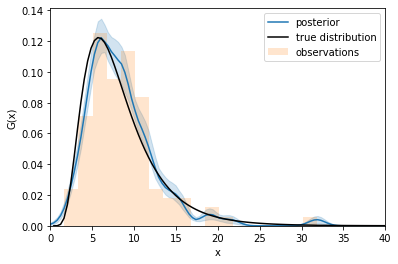

In [150]:
# The kernel
def density_posterior(x, kernel_bw=1, percentile=[5, 50, 95]): 
    X = x
    for size in phi_k.shape:
        X = np.repeat(X[..., np.newaxis], size, axis=-1)
    return np.percentile(np.mean(
                        np.exp(-0.5*((X-phi_k)/kernel_bw)**2)/np.sqrt(2*np.pi*kernel_bw**2), axis=-1), 
                        percentile, axis=-1)

x = np.linspace(0, 40, 100)

G = density_posterior(x)
plt.plot(x, G[1,:], label='posterior', c='C0')
plt.fill_between(x, G[0,:], G[2,:], alpha=0.2, color='C0')

plt.hist(observations, bins=np.linspace(0, max(observations), 20), color='C1', 
         density=True, alpha=0.2, label='observations')

plt.plot(x, true_dist.probability(x), 'k-', label='true distribution')

plt.xlabel("x")
plt.ylabel("G(x)")
plt.xlim(0, 40)
plt.legend()
plt.show()

The above densitty estimation works quite well. but this is only because we chose the parameter $\alpha$ and $H$ carefully. Alternative choices (e.g. $\alpha=10$, $\mathrm{mean}=0$ and $\mathrm{stddev}=10$) lead to significantly worse performance. The solution is marginalise over these parameters.


# Density Estimation: Marginalised Hyperparameters

The concentration parameter
$$ \alpha \sim \mathrm{Gamma}(2, 10). $$

The base distribution
$$ H = \mathcal{N}(\mu, \sigma^2), $$
where 
$$ \mu \sim \mathcal{N}(1, 4), $$
$$ \sigma \sim \mathrm{Gamma}(2, 1/2), $$

In [88]:
# Number of cluster and posterior draws
N, K = 100, 100

# Hyperparameter priors
pi_alpha = gamma(2, scale=10)
pi_mu = norm(1.4, scale=1)
pi_sigma = gamma(2, scale=1/2)

alpha = pi_alpha.rvs(N)
mu = pi_mu.rvs(N)
sigma = pi_sigma.rvs(N)

# Observed distribution
observed_dist = DiscreteDistribution(dict(zip(observations, np.ones(n)/n)))

# Stick-breaking construction for the weights...
pi_k = GEM(alpha+len(observations), K=K)

# Draw the atoms
H_dists = [NormalDistribution(mu[i], sigma[i]) for i in range(N)]
P_dists = [GeneralMixtureModel([H_dists[i], observed_dist], weights=[n/(alpha[i]+n), alpha[i]/(alpha[i]+n)])
            for i in range(N)]
phi_k = np.array([P.sample(K) for P in P_dists]).T

# Posterior
#posterior_dist = DiscreteDistribution(dict(zip(phi_k, pi_k)))


In [86]:
phi_k.shape

(1000, 100)

In [87]:
pi_k.shape

(100, 1000)